# ARIMA Model

In [ ]:
# Import libraries
from pandas import read_csv
from matplotlib import pyplot
from numpy import sqrt
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
series = read_csv('CocaCola_Sales_Rawdata.csv',header=0, index_col=0, parse_dates=True)
series

,Sales
Quarter,
Q1_86,1734.827000
Q2_86,2244.960999
Q3_86,2533.804993
Q4_86,2154.962997
Q1_87,1547.818996
Q2_87,2104.411995
Q3_87,2014.362999
Q4_87,1991.746998
Q1_88,1869.049999


In [ ]:
series.shape

(42, 1)

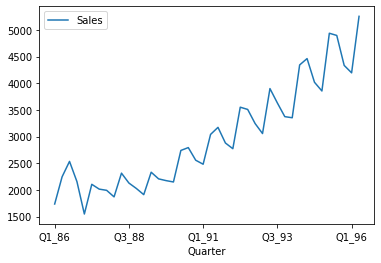

In [ ]:
# line plot of time series
from pandas import read_csv
from matplotlib import pyplot
series.plot()
pyplot.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2f19dbe050>]],
      dtype=object)

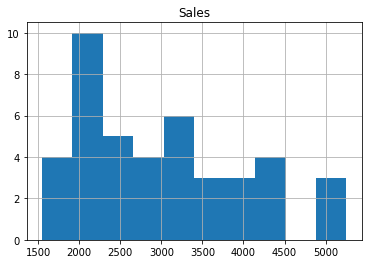

In [ ]:
series.hist()

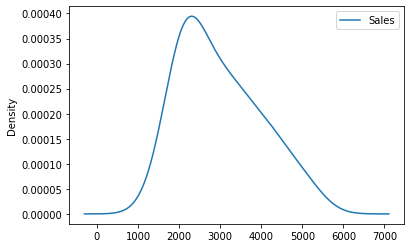

In [ ]:
series.plot(kind='kde')

In [ ]:
# separate out a validation dataset
split_point = len(series) - 10
dataset, validation = series[0:split_point], series[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv', header=False)
validation.to_csv('validation.csv', header=False)

Dataset 32, Validation 10


#### Persistence/ Base model

In [ ]:
# evaluate a persistence model
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from math import sqrt
# load data
train = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = train.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]


In [ ]:
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    yhat = history[-1]
    predictions.append(yhat)
# observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=2173.968, Expected=2148.278
>Predicted=2148.278, Expected=2739.308
>Predicted=2739.308, Expected=2792.754
>Predicted=2792.754, Expected=2556.010
>Predicted=2556.010, Expected=2480.974
>Predicted=2480.974, Expected=3039.523
>Predicted=3039.523, Expected=3172.116
>Predicted=3172.116, Expected=2879.001
>Predicted=2879.001, Expected=2772.000
>Predicted=2772.000, Expected=3550.000
>Predicted=3550.000, Expected=3508.000
>Predicted=3508.000, Expected=3243.860
>Predicted=3243.860, Expected=3056.000
>Predicted=3056.000, Expected=3899.000
>Predicted=3899.000, Expected=3629.000
>Predicted=3629.000, Expected=3373.000
RMSE: 387.510


#### ARIMA Hyperparameters

In [ ]:
# grid search ARIMA parameters for a time series

import warnings
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt


# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
# prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.50)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
# make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
# model_fit = model.fit(disp=0)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
# calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

#### Grid search for p,d,q values

In [ ]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float('inf'), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(train, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [ ]:
# load dataset
train = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# evaluate parameters
p_values = range(0, 5)
d_values = range(0, 5)
q_values = range(0, 5)
warnings.filterwarnings("ignore")
evaluate_models(train.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=840.936
ARIMA(0, 0, 1) RMSE=617.891
ARIMA(0, 0, 2) RMSE=450.670
ARIMA(0, 1, 0) RMSE=389.741
ARIMA(0, 1, 1) RMSE=396.142
ARIMA(0, 1, 2) RMSE=354.964
ARIMA(0, 1, 4) RMSE=272.869
ARIMA(0, 2, 0) RMSE=593.232
ARIMA(0, 2, 1) RMSE=414.867
ARIMA(1, 0, 0) RMSE=470.343
ARIMA(1, 1, 0) RMSE=387.222
ARIMA(1, 2, 0) RMSE=574.838
ARIMA(2, 0, 0) RMSE=493.077
ARIMA(2, 1, 0) RMSE=300.157
ARIMA(2, 1, 1) RMSE=327.956
ARIMA(2, 2, 0) RMSE=485.191
ARIMA(3, 0, 0) RMSE=431.275
ARIMA(3, 1, 0) RMSE=245.267
ARIMA(3, 2, 0) RMSE=156.740
ARIMA(4, 0, 0) RMSE=387.570
ARIMA(4, 1, 0) RMSE=163.620
ARIMA(4, 2, 0) RMSE=161.625
Best ARIMA(3, 2, 0) RMSE=156.740


#### Build Model based on the optimized values

In [ ]:
# save finalized model to file
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMA
import numpy

In [ ]:
# load data
train = read_csv('dataset.csv', header=0, index_col=0, parse_dates=True)
# prepare data
X = train.values
X = X.astype('float32')

In [ ]:
# fit model
model = ARIMA(X, order=(3,2,0))
model_fit = model.fit()
forecast=model_fit.forecast(steps=10)[0]
model_fit.plot_predict(1,42)

In [ ]:
#Error on the test data
val=pd.read_csv('validation.csv',header=None)
rmse = sqrt(mean_squared_error(val[1], forecast))
rmse

490.365198057776

#### Combine train and test data and build final model

In [ ]:
 #fit model
data = read_csv('CocaCola_Sales_Rawdata.csv', header=0, index_col=0, parse_dates=True)
# prepare data
X = train.values
X = X.astype('float32')

In [ ]:
model = ARIMA(X, order=(3,2,0))
model_fit = model.fit()

In [ ]:
forecast=model_fit.forecast(steps=10)[0]
model_fit.plot_predict(1,43)

In [ ]:
forecast

array([3322.02175896, 4107.59111231, 3796.0767598 , 3577.04884298,
       3647.1065077 , 4366.89186344, 4023.36607486, 3855.11613714,
       4029.48289361, 4677.51710295])

# Data Driven Models

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing 

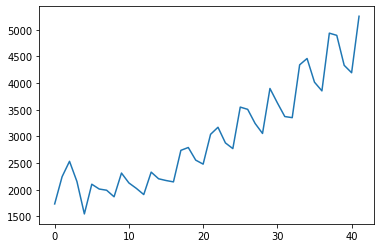

In [ ]:
Walmart = pd.read_csv('CocaCola_Sales_Rawdata.csv')
Walmart.Sales.plot()

### Splitting data

In [ ]:
Train = Walmart.head(32)
Test = Walmart.tail(10)

### Moving Average

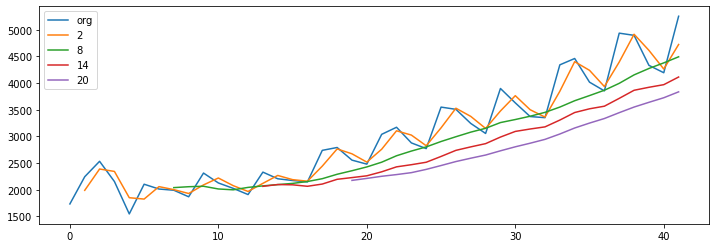

In [ ]:
plt.figure(figsize=(12,4))
Walmart.Sales.plot(label="org")
for i in range(2,24,6):
    Walmart["Sales"].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')

### Time series decomposition plot

In [ ]:
decompose_ts_add = seasonal_decompose(Walmart.Sales,period=12)
decompose_ts_add.plot()
plt.show()

TypeError: ignored

### ACF plots and PACF plots

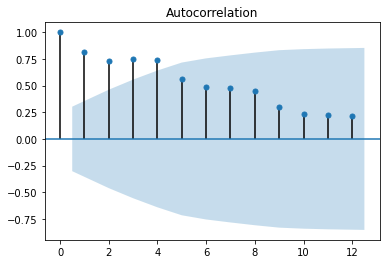

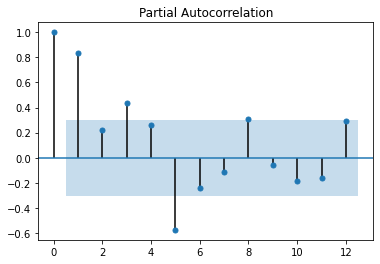

In [ ]:
import statsmodels.graphics.tsaplots as tsa_plots
tsa_plots.plot_acf(Walmart.Sales,lags=12)
tsa_plots.plot_pacf(Walmart.Sales,lags=12)
plt.show()

### Evaluation Metric RMSE

In [ ]:
def RMSE(pred,org):
    sale=np.mean((pred-org)**2)
    return np.sqrt(sale)

### Simple Exponential Method

In [ ]:
ses_model = SimpleExpSmoothing(Train["Sales"]).fit(smoothing_level=0.2)
pred_ses = ses_model.predict(start = Test.index[0],end = Test.index[-1])
RMSE(pred_ses,Test.Sales) 

1172.175630211133

### Holt method

In [ ]:
hw_model = Holt(Train["Sales"]).fit(smoothing_level=0.2, smoothing_slope=0.8)
pred_hw = hw_model.predict(start = Test.index[0],end = Test.index[-1])
RMSE(pred_hw,Test.Sales)

649.6581862383966

### Holts winter exponential smoothing with additive seasonality and additive trend

In [ ]:
hwe_model_add_add = ExponentialSmoothing(Train["Sales"],seasonal="add",trend="add",seasonal_periods=12).fit() #add the trend to the model
pred_hwe_add_add = hwe_model_add_add.predict(start = Test.index[0],end = Test.index[-1])
RMSE(pred_hwe_add_add,Test.Sales) 

614.6623875945043

### Holts winter exponential smoothing with multiplicative seasonality and additive trend

In [ ]:
hwe_model_mul_add = ExponentialSmoothing(Train["Sales"],seasonal="mul",trend="add",seasonal_periods=12).fit() 
pred_hwe_mul_add = hwe_model_mul_add.predict(start = Test.index[0],end = Test.index[-1])
RMSE(pred_hwe_mul_add,Test.Sales)

552.8587858766489

## Final Model by combining train and tes

In [ ]:
hwe_model_add_add = ExponentialSmoothing(Walmart["Sales"],seasonal="add",trend="add",seasonal_periods=12).fit()

In [ ]:
#Forecasting for next 10 time periods
hwe_model_add_add.forecast(10)

42    4944.455880
43    4760.824936
44    4794.885955
45    5679.607827
46    5708.234650
47    5275.603235
48    5156.169958
49    6126.061343
50    5998.836745
51    5520.530408
dtype: float64